In [ ]:
!pip install transformers
!pip install accelerate -U
!pip install datasets
!pip install rouge_score
!pip install tiktoken
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for ro

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import statistics
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TrainingArguments, Trainer
import tiktoken

In [ ]:
!wget -O Dataset-1.zip https://github.com/ch22group16/capstone-GenAI/raw/main/dataset/Dataset-1-20240909T162549Z-001.zip
!wget -O Dataset-2.zip https://github.com/ch22group16/capstone-GenAI/raw/main/dataset/Dataset-2-20240909T162549Z-001.zip
%rm -rf /content/Dataset-1/ /content/Dataset-2/

import zipfile
import os

def extract_zip(zip_path, extract_to):
    # Ensure the extraction directory exists
    os.makedirs(extract_to, exist_ok=True)

    # Open the ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extract all the contents to the specified directory
        zip_ref.extractall(extract_to)

zip_path = ['/content/Dataset-1.zip', '/content/Dataset-2.zip']
extract_to = '/content'
for path in zip_path:
  extract_zip(path, extract_to)

--2024-09-15 05:11:43--  https://github.com/ch22group16/capstone-GenAI/raw/main/dataset/Dataset-1-20240909T162549Z-001.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ch22group16/capstone-GenAI/main/dataset/Dataset-1-20240909T162549Z-001.zip [following]
--2024-09-15 05:11:43--  https://raw.githubusercontent.com/ch22group16/capstone-GenAI/main/dataset/Dataset-1-20240909T162549Z-001.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150066 (147K) [application/zip]
Saving to: ‘Dataset-1.zip’

Dataset-1.zip       100%[===================>] 146.55K  --.-KB/s    in 0.02s   

2024-09-15 05:11:43 (

In [ ]:
# Load the Excel files into DataFrames
dftr = pd.concat([pd.read_excel('/content/Dataset-1/aiml-qa-train.xlsx'),
                  pd.read_csv('/content/Dataset-2/train.csv'),
                  pd.read_csv('/content/Dataset-2/dev.csv'),
                  pd.read_excel('/content/Dataset-1/aiml-qa-dev.xlsx', usecols=[0,1], names=['question', 'answer']),
                  pd.read_excel('/content/Dataset-1/aiml-qa-dev.xlsx', usecols=[0,2], names=['question', 'answer'])])
dfts1 = pd.read_excel("/content/Dataset-1/aiml-qa-test.xlsx")
dfts2 = pd.read_csv("/content/Dataset-2/test.csv")

dfs = [dftr, dfts1, dfts2]

In [ ]:
dftr.shape, dfts1.shape, dfts2.shape

((3709, 2), (120, 3), (249, 2))

In [ ]:
# create list of dictionaries
train_data = []; test_data1 = []; test_data2 = [];
for df in dfs:
  if df.equals(dftr):
    for index, row in df.iterrows():
      train_data += [{'question': row.iloc[0], 'answer' : row.iloc[1]}]
  elif df.equals(dfts1):
    for index, row in df.iterrows():
        test_data1 += [{'question': row.iloc[0], 'answer' : row.iloc[1]}]
        test_data1 += [{'question': row.iloc[0], 'answer' : row.iloc[2]}]
  else:
    for index, row in df.iterrows():
        test_data2 += [{'question': row.iloc[0], 'answer' : row.iloc[1]}]

datas = [train_data, test_data1, test_data2]
print(len(train_data), len(test_data1), len(test_data2))

3709 240 249


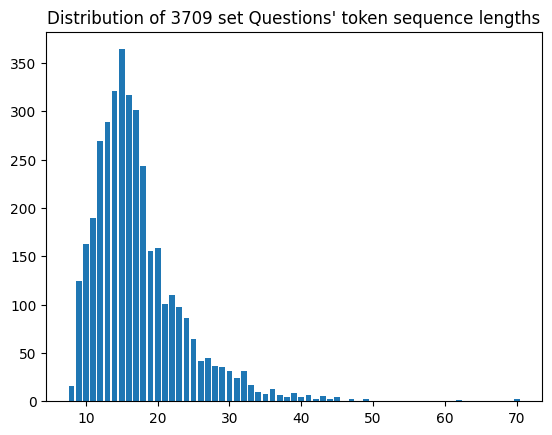

q-mean : 17.19, q-std : 6.19
q-max : 70 , q-min : 8


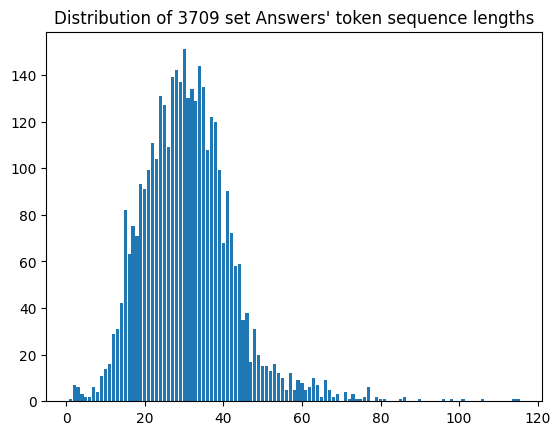

a-mean : 31.00, a-std : 11.75
a-max : 115 , a-min : 1


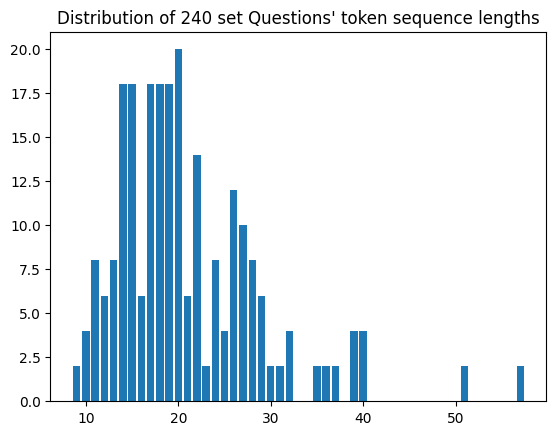

q-mean : 21.09, q-std : 8.11
q-max : 57 , q-min : 9


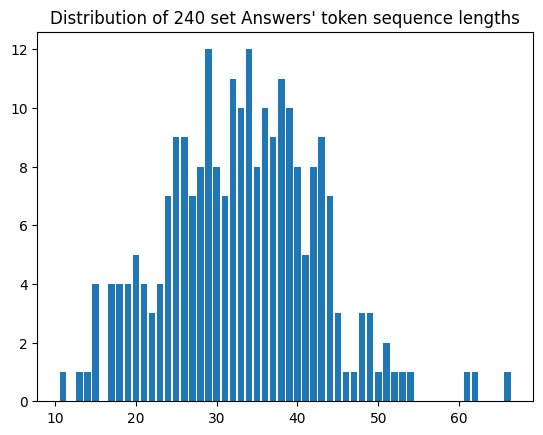

a-mean : 33.11, a-std : 9.35
a-max : 66 , a-min : 11


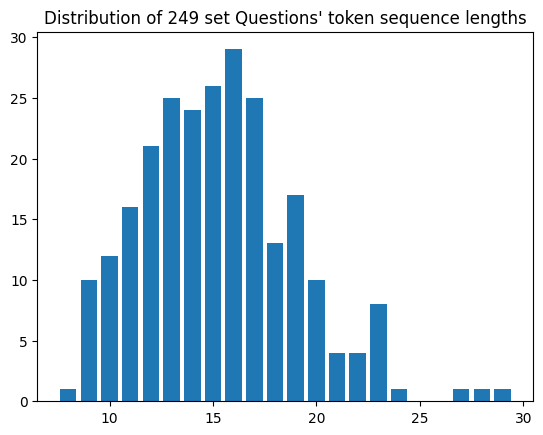

q-mean : 15.29, q-std : 3.74
q-max : 29 , q-min : 8


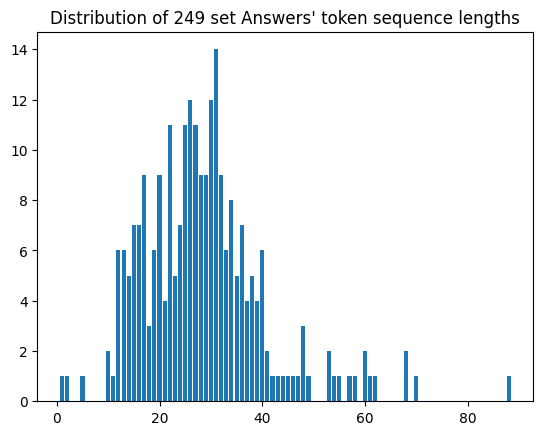

a-mean : 28.53, a-std : 12.18
a-max : 88 , a-min : 1


In [ ]:
# Visualizing the dataset

enc = tiktoken.get_encoding("gpt2")

def visualize_dataset(data):
  q = []; a = []
  for qna in data:
    q.append(len((enc.encode(f"Q: {qna['question']} A:"))))
    a.append(len((enc.encode(qna['answer']))))

  dq = {}; da = {}
  for out in q:
    dq[out] = dq.get(out, 0) + 1
  dist_q = dict(sorted(dq.items())) # sort based on keys

  for out in a:
    da[out] = da.get(out, 0) + 1
  dist_a = dict(sorted(da.items()))

  kq = list(dist_q.keys())
  vq = list(dist_q.values())

  fig, ax = plt.subplots()
  bars = ax.bar(kq, vq)
  ax.set_title(f"Distribution of {len(data)} set Questions' token sequence lengths")
  plt.show()

  print(f"q-mean : {statistics.mean(q):.2f}, q-std : {statistics.stdev(q):.2f}")
  print(f"q-max : {max(q)} , q-min : {min(q)}")

  ka = list(dist_a.keys())
  va = list(dist_a.values())

  fig, ax = plt.subplots()
  bars = ax.bar(ka, va)
  ax.set_title(f"Distribution of {len(data)} set Answers' token sequence lengths")
  plt.show()

  print(f"a-mean : {statistics.mean(a):.2f}, a-std : {statistics.stdev(a):.2f}")
  print(f"a-max : {max(a)} , a-min : {min(a)}")

for data in datas:
  visualize_dataset(data)

In [ ]:
# Improrting the model form Hugging face

# Load the tokenizer and model
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

124,439,808 total parameters.
124,439,808 training parameters.


In [ ]:
#  ZERO SHOT TESTING

#Define your input text
input_text = "What is the difference between concatenation vs. summation of two tensors?"
input_ids = tokenizer.encode(input_text,
                             max_length=512,
                             truncation=True,
                             return_tensors='pt',
                             ).to(device)

# Create an attention mask and move it to the same device
attention_mask = torch.ones(input_ids.shape, device=device)

# Generate text
outputs = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    max_new_tokens = 50,
    top_p=0.9,
    top_k=50
)

# Decode the generated text
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


What is the difference between concatenation vs. summation of two tensors?

The difference between concatenation vs. summation of two tensors is that the two tensors are not the same. The two tensors are the same.

The difference between concatenation vs. summation of two tens


In [ ]:
import json
with open('train_file.json', 'w') as file:
    json.dump(train_data, file)

In [ ]:
# Tokenize the train dataset
from datasets import load_dataset
dataset = load_dataset('json', data_files = {'train':'train_file.json'})
tokenizer.pad_token = tokenizer.eos_token
def preprocess_function(examples):
    inputs = ['Q: ' + q + ' A:' + a + tokenizer.eos_token for q, a in zip(examples['question'], examples['answer'])]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")
    labels = model_inputs['input_ids'].copy()
    model_inputs['labels'] = labels
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3709 [00:00<?, ? examples/s]

In [ ]:
# Training arguments
batch_size = 4
num_epochs = 20
train_dataset_size = len(tokenized_dataset['train'])
steps_per_epoch = train_dataset_size // batch_size

training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",    # output directory
    overwrite_output_dir=True,        # output directory
    num_train_epochs=num_epochs,      # number of epochs
    per_device_train_batch_size=4,    # batch size for training
    per_device_eval_batch_size=4,     # batch size for evaluation
    #eval_strategy="epoch",           # evaluate every epoch
    logging_dir="./logs",
    logging_steps=steps_per_epoch,
    save_strategy="epoch",            # save checkpoints at end of epoch
    save_total_limit=1,               # save only latest check point
    #prediction_loss_only = True       # Ensures only loss is computed during evaluation
    #load_best_model_at_end=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    #eval_dataset=tokenized_dataset['dev'],
)

# Fine-tune the model
trainer.train()

Step,Training Loss
927,0.478400
1854,0.376900
2781,0.316400
3708,0.271300
4635,0.235200
5562,0.205700
6489,0.180900
7416,0.160600
8343,0.144000
9270,0.129600


TrainOutput(global_step=18560, training_loss=0.16917405118202342, metrics={'train_runtime': 6021.4508, 'train_samples_per_second': 12.319, 'train_steps_per_second': 3.082, 'total_flos': 9691321466880000.0, 'train_loss': 0.16917405118202342, 'epoch': 20.0})

In [ ]:
def generate_answer(question):
    input_ids = tokenizer.encode('Q: ' + question + ' A:', return_tensors='pt').to(device)
    attention_mask = torch.ones(input_ids.shape, device=device)
    output = model.generate(input_ids, attention_mask = attention_mask, max_new_tokens=60)
    gen_text = tokenizer.decode(output[0], skip_special_tokens=True)
    question, answer = gen_text.split(' A:', maxsplit=1)
    return answer
dfts1['generated_answer'] = dfts1['question'].apply(generate_answer)
dfts2['generated_answer'] = dfts2['question'].apply(generate_answer)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [ ]:
dfts1.head() # generated answers for test data-1

,question,answer1,answer2,generated_answer
0,How we can effectively convert 2D images to 1D?,Converting images to 1D data may not be effect...,"To effectively convert 2D images to 1D, use te...","By using 2D data with live processing, we can ..."
1,Can we utilize an autoencoder to perform dimen...,"Yes, autoencoders can be applied to numerical ...","Yes, autoencoders can be used for dimensionali...","Yes, autoencoders can indeed reduce dimensiona..."
2,What is NLP's current biggest challenge that i...,The main challenges of NLP is finding and coll...,NLP models struggle with tasks that require re...,NLP's current biggest challenge is being used ...
3,Which problems cannot be solved by Neural netw...,While neural networks have shown great success...,"Neural networks are powerful, but they may str...","Yes, problems can be solved by neural networks..."
4,Is scaling necessary for SVM?,"Yes, scaling the input data is generally recom...",Scaling the input data is advisable when utili...,"Yes, scaling is recommended for SVM to ensure ..."


In [ ]:
dfts2.head() # generated answers for test data-2

,question,answer,generated_answer
0,What is feature selection?,The process of selecting a subset of relevant ...,The process of selecting a subset or set of re...
1,"What are Markov decision processes (MDP), and ...",MDPs are mathematical frameworks for modeling ...,MDPs are a type of unsupervised learning where...
2,What is batch normalization and how does it work?,Normalizes the layer's input over a mini-batch,Batch normalization is a technique used to nor...
3,How does Word2Vec create word embeddings?,Word2Vec creates word embeddings by training o...,Word2Vec creates word embeddings by taking the...
4,What is the role of hidden layers in MLP?,Hidden layers in MLP help capture complex patt...,Hidden layers in neural networks allow models ...


In [ ]:
# Calculate ROUGE scores for test dataset-1 with Two Answers
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores1 = []; rouge_scores2 = []
for index, row in dfts1.iterrows():
    target_answer1 = row['answer1']
    target_answer2 = row['answer2']
    generated_answer = row['generated_answer']
    scores1 = scorer.score(target_answer1, generated_answer)
    scores2 = scorer.score(target_answer2, generated_answer)
    rouge_scores1.append(scores1)
    rouge_scores2.append(scores2)

# Print average ROUGE scores
avg_rouge1 = (sum([score['rouge1'].fmeasure for score in rouge_scores1]) + sum([score['rouge1'].fmeasure for score in rouge_scores2])) / (2 * len(rouge_scores2))
avg_rouge2 = (sum([score['rouge2'].fmeasure for score in rouge_scores1]) + sum([score['rouge2'].fmeasure for score in rouge_scores2])) / (2 * len(rouge_scores2))
avg_rougeL = (sum([score['rougeL'].fmeasure for score in rouge_scores1]) + sum([score['rougeL'].fmeasure for score in rouge_scores2])) / (2 * len(rouge_scores2))

print(f"Average ROUGE-1 Score: {avg_rouge1}")
print(f"Average ROUGE-2 Score: {avg_rouge2}")
print(f"Average ROUGE-L Score: {avg_rougeL}")

Average ROUGE-1 Score: 0.3310784698525723
Average ROUGE-2 Score: 0.12949412979741162
Average ROUGE-L Score: 0.26175937555795203


In [ ]:
# Calculate ROUGE scores for test dataset-2 with one Answer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores = []
for index, row in dfts2.iterrows():
    target_answer = row['answer']
    generated_answer = row['generated_answer']
    scores = scorer.score(target_answer, generated_answer)
    rouge_scores.append(scores)

# Print average ROUGE scores
avg_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)

print(f"Average ROUGE-1 Score: {avg_rouge1}")
print(f"Average ROUGE-2 Score: {avg_rouge2}")
print(f"Average ROUGE-L Score: {avg_rougeL}")

Average ROUGE-1 Score: 0.36956118319733666
Average ROUGE-2 Score: 0.16392918775217533
Average ROUGE-L Score: 0.3127743307192723


In [ ]:
# Human Evaluation

def ask_question(question):
    inputs = tokenizer.encode('Q: ' + question + ' A:', return_tensors='pt').to(device)
    attention_mask = torch.ones(inputs.shape, device=device)
    outputs = model.generate(inputs, attention_mask = attention_mask, max_new_tokens=100, num_return_sequences=1)
    gen_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    question, answer = gen_text.split(' A:')
    return question, answer

print(ask_question("What is the difference between concatenation vs. summation of two tensors?"))
print(ask_question("What are the other applications of unsupervised learning than clustering?"))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


('Q: What is the difference between concatenation vs. summation of two tensors?', 'Concatenation combines two tensors along a chosen axis, whereas summation combines two tensors element-wise, maintaining the tensor shape.')
('Q: What are the other applications of unsupervised learning than clustering?', 'Other applications of unsupervised learning include clustering in unsupervised tasks like identifying patterns in data, discovering hidden structures in unlabeled data, and discovering hidden clusters in unlabeled data.')
